## Sequence to Sequence

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import pickle as pkl
# 파일을 저장하는 모듈
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
# model 구축에 사용할 라이브러리
import pydot as pyd
# 신경망을 시각적으로 확인하기에 용이한 라이브러리
import keras
from keras.utils.vis_utils import plot_model, model_to_dot


keras.utils.vis_utils.pydot = pyd

### 1) Data Load

* random sensor data 생성

In [3]:
n_ = 1000
# random noise 크기 설정
t = np.linspace(0, 50*np.pi,n_) 
# np.linspace(x, y, z) : x에서 y사이 z개의 1차원 배열을 만들어라.
# 0에서 50pi까지 1000개의 random한 배열 만들기

In [4]:
t

array([  0.        ,   0.15723687,   0.31447374,   0.47171061,
         0.62894748,   0.78618435,   0.94342122,   1.10065809,
         1.25789496,   1.41513183,   1.5723687 ,   1.72960557,
         1.88684243,   2.0440793 ,   2.20131617,   2.35855304,
         2.51578991,   2.67302678,   2.83026365,   2.98750052,
         3.14473739,   3.30197426,   3.45921113,   3.616448  ,
         3.77368487,   3.93092174,   4.08815861,   4.24539548,
         4.40263235,   4.55986922,   4.71710609,   4.87434296,
         5.03157983,   5.1888167 ,   5.34605356,   5.50329043,
         5.6605273 ,   5.81776417,   5.97500104,   6.13223791,
         6.28947478,   6.44671165,   6.60394852,   6.76118539,
         6.91842226,   7.07565913,   7.232896  ,   7.39013287,
         7.54736974,   7.70460661,   7.86184348,   8.01908035,
         8.17631722,   8.33355409,   8.49079096,   8.64802783,
         8.80526469,   8.96250156,   9.11973843,   9.2769753 ,
         9.43421217,   9.59144904,   9.74868591,   9.90

In [5]:
len(sum([20*np.sin(i*t+np.pi) for i in range(5)]))
# 5번 반복하여 i를 뽑아서 i에 위와 같은 연산을 하여 1000개의 random array를 생성후 더한다.
# 총 1000개의 random array 생성

1000

In [6]:
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0,6,n_)
# t의 2차항을 더하고 random noise를 다시 더한다. -> 2차항 존재
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0,6,n_)
# t의 1차항을 더하여 random noise를 다시 더한다. -> 1차항 존재

In [7]:
len(x1)

1000

In [8]:
len(x2)

1000

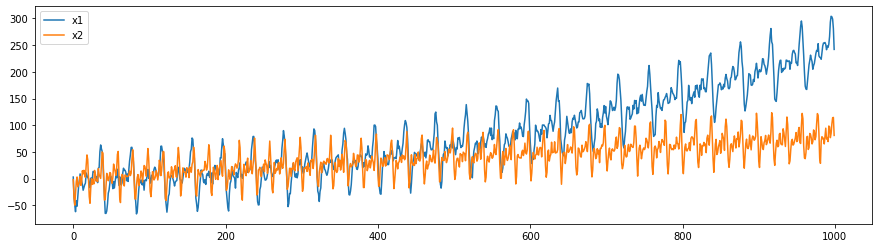

In [9]:
plt.figure(figsize=(15,4))
plt.plot(range(len(x1)), x1 , label='x1')
plt.plot(range(len(x2)), x2 , label='x2')
plt.legend()
plt.show()
# 시각적으로 x1은 2차항을 가진 추세
# x2는 1차항을 가진 추세

### 2) Data 전처리

In [10]:
train_ratio = 0.8
# train data의 비율을 0.8로 설정
train_len = int(train_ratio * t.shape[0])
print(train_len)
# 800개의 data point들이 train으로 나머지 200개를 test로 사용

800


2-1) Detrending : 데이터 추세 제거, 완벽하게 알 수 없지만 어느정도의 경향을 제거

In [11]:
x_index = np.array(range(len(t)))
# noise의 수 만큼 index를 정의
print(len(x_index))

1000


In [12]:
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len],2)
# 각 x(index)와 대응하는 y값 그리고 차수를 입력하여 다항식의 파라미터를 구한다.
# np.polyfit : 최소 제곱을 갖는 다항식 trend의 차수가 알려져있다고 가정 -> 2차
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len],1)
# np.polyfit : 최소 제곱을 갖는 다항식 trend의 차수가 알려져있다고 가정 -> 1차
print(x1_trend_param)
# 파라미터를 출력해본다.
print(x2_trend_param)

[ 2.45236255e-04  6.67390840e-03 -2.35294338e+00]
[ 0.07892796 -0.08015394]


In [13]:
x1_trend = (x_index**2)*x1_trend_param[0] + x_index*x1_trend_param[1] + x1_trend_param[2]
# 위에서 구한 파라미터로 2차 방정식 추세를 정의(trend 선)
x2_trend = x_index*x2_trend_param[0] + x2_trend_param[1]
# 1차 방정식 추세를 정의(trend 선)

→ 추세를 제거하는 전처리 작업을 많이 진행

* Noise data에 trend를 시각화

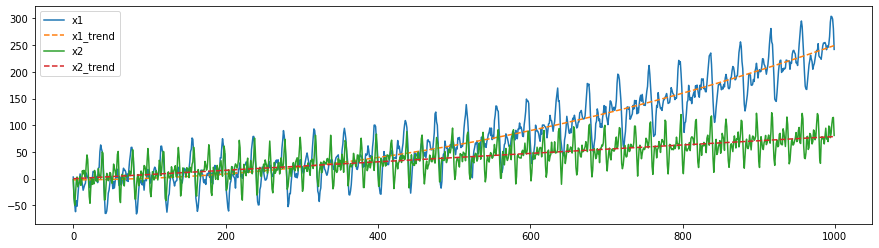

In [14]:
plt.figure(figsize=(15,4))
plt.plot(range(len(x1)), x1 , label='x1')
# x1
plt.plot(range(len(x1_trend)), x1_trend , linestyle="--" , label='x1_trend')
# x1의 trend
plt.plot(range(len(x2)), x2 , label='x2')
# x2
plt.plot(range(len(x2_trend)), x2_trend , linestyle="--", label='x2_trend')
# x2의 trend
plt.legend()
plt.show()

* Trend를 제거 : 분석에 용이

In [15]:
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend 
# 원래 값에서 추세 선의 값 만큼 뺴준다.

* 추세 제거 후 Noise data 시각화

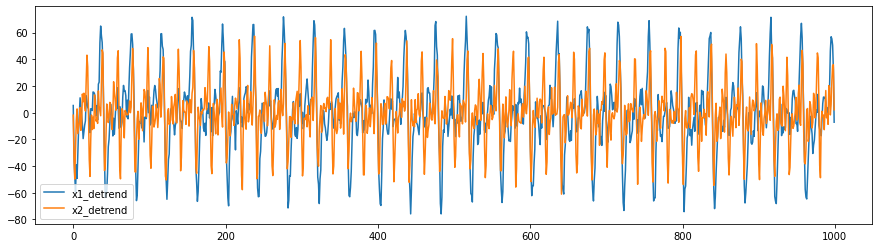

In [16]:
plt.figure(figsize=(15,4))
plt.plot(range(len(x1_detrend)), x1_detrend, label="x1_detrend")
plt.plot(range(len(x2_detrend)), x2_detrend, label="x2_detrend")
plt.legend()
plt.show()

2-2) np.array 배열로 변환 : 전처리 작업을 위해

In [17]:
x_lbl = np.column_stack([x1_detrend,x2_detrend,x_index, [1]*train_len+ [0]*(len(x_index)-train_len)])
# np.column_stack : array 배열 붙이기
# trend가 제거된 x1, trend가 제거된 x2, index, (train : 1, test : 0)
# train/test를 구분하기 위해 800개는 1, 200개는 0으로 지정

In [18]:
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[  5.36400185  -1.86271594   0.           1.        ]
 [-29.66769    -36.2522025    1.           1.        ]
 [-47.34085249 -49.721605     2.           1.        ]
 ...
 [ 50.4945872   35.35732574 997.           0.        ]
 [ 31.96888672  35.93710781 998.           0.        ]
 [ -7.15757212   2.15137748 999.           0.        ]]


2-3) Normalize

* x1과 x2에(noise data) 대해서만 정규화 처리 : index와 label은 당연히 안해도됨.

In [19]:
x_lbl[:,3] # label

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [20]:
x_lbl[x_lbl[:,3]==1, :2]
# train에 해당하는 데이터만 가져오기

array([[  5.36400185,  -1.86271594],
       [-29.66769   , -36.2522025 ],
       [-47.34085249, -49.721605  ],
       ...,
       [ 60.23880426,  37.18108518],
       [ 37.63849602,  57.06442529],
       [ 10.38527254,   4.62320772]])

In [21]:
x_train_max = x_lbl[x_lbl[:,3]==1, :2].max(axis=0)
# label이 train(=1)에 해당하는 x1, x2에 값중 max

In [22]:
x_train_max

array([72.21767979, 57.36381662])

In [23]:
x_train_max = x_train_max.tolist() + [1]*2 
# 앞의 두개의 열의 데이터만 정규화할것.(최대 값으로 나눌것) 따라서 그 뒤의 열은 max를 1로 설정
# 뒤의 값은 index, label인데 동시에 나누기 편하게 하기 위해 1,1로 설정
print(x_train_max)

[72.21767978648987, 57.36381662174705, 1, 1]


In [24]:
x_normalize = np.divide(x_lbl, x_train_max)
# 전체 데이터를 각 데이터열의 max로 나눈다.
# index와 label은 1로 나누기에 문제 없음.
# train의 지표로 test도 나누는 이유는, test를 사용하게 되면 data leakage 발생 우려
print(x_normalize)

[[ 7.42754664e-02 -3.24719667e-02  0.00000000e+00  1.00000000e+00]
 [-4.10809238e-01 -6.31969848e-01  1.00000000e+00  1.00000000e+00]
 [-6.55529957e-01 -8.66776444e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 6.99199799e-01  6.16369827e-01  9.97000000e+02  0.00000000e+00]
 [ 4.42673966e-01  6.26476931e-01  9.98000000e+02  0.00000000e+00]
 [-9.91110783e-02  3.75040854e-02  9.99000000e+02  0.00000000e+00]]


In [25]:
x_normalize.shape
# x1, x2, index, label

(1000, 4)

* 시각화

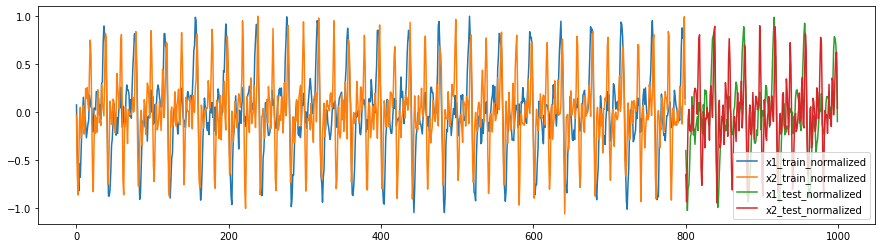

In [26]:
plt.figure(figsize=(15,4))
plt.plot(range(train_len), x_normalize[:train_len,0], label="x1_train_normalized")
# 정규화 시킨 train_x1
plt.plot(range(train_len), x_normalize[:train_len,1], label="x2_train_normalized")
# 정규화 시킨 train_x2
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:,0], label="x1_test_normalized")
# 정규화 시킨 test_x1
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:,1], label="x2_test_normalized")
# 정규화 시킨 test_x2
plt.legend()
plt.show()

2-4) Truncate : input window, ouputwindow

앞선 200 point의 추세로 다음 20 point의 추세를 예측할 것이다. 

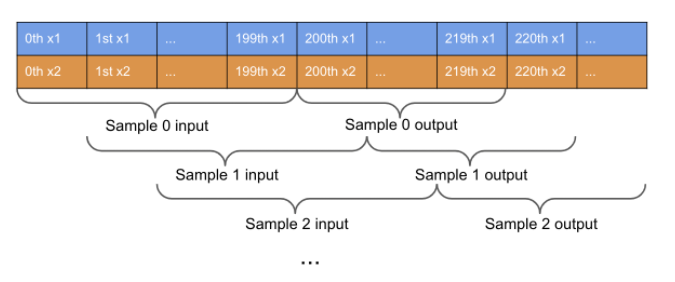

In [27]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/05/trun.png')

In [28]:
x_normalize.shape

(1000, 4)

In [29]:
x_normalize[0:(200), range(0, 3)]
# 200개의 x1, x2, index

array([[ 7.42754664e-02, -3.24719667e-02,  0.00000000e+00],
       [-4.10809238e-01, -6.31969848e-01,  1.00000000e+00],
       [-6.55529957e-01, -8.66776444e-01,  2.00000000e+00],
       [-8.23992594e-01, -4.57644260e-01,  3.00000000e+00],
       [-5.39281969e-01, -9.86459279e-02,  4.00000000e+00],
       [-6.81760798e-01,  4.89863999e-02,  5.00000000e+00],
       [-4.32984569e-01, -2.73821065e-01,  6.00000000e+00],
       [-1.76390728e-01, -2.01003760e-01,  7.00000000e+00],
       [-5.97697343e-03, -1.18299321e-01,  8.00000000e+00],
       [ 1.54030181e-01,  6.58361692e-02,  9.00000000e+00],
       [ 6.33974669e-02, -2.30774213e-01,  1.00000000e+01],
       [-2.30470016e-02, -1.57810133e-01,  1.10000000e+01],
       [-1.19060937e-01,  2.43722944e-01,  1.20000000e+01],
       [-2.69211047e-01,  1.42659128e-01,  1.30000000e+01],
       [-1.94631273e-01,  2.54386501e-01,  1.40000000e+01],
       [-1.29650813e-01,  9.10664896e-02,  1.50000000e+01],
       [-8.46135363e-02,  2.11152875e-02

In [30]:
len(x_normalize[0:(200), range(0, 3)])

200

In [31]:
def truncate(x, feature_cols = range(3), target_cols = range(3), 
             label_col = 3, train_len = 200, test_len = 20): 
             
    in_, out_, lbl = [], [], []
    for i in range(len(x) - train_len - test_len +1):
        # range안은 맨 마지막 step을 정의하는 공간 
        # i번 부터 마지막 step까지(train+test 제외) index 차례대로 가져오기
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        # i번 부터 i+200개까지 200 point step가져오기 : 학습할 스텝
        out_.append(x[(i+train_len):(i+train_len+test_len),target_cols].tolist())
        # in_의 다음 step부터 20개까지 step가져오기 : 이후 예측해야하는 값
        lbl.append(x[i+train_len, label_col])
        # label = train용인지 test용인지 구분
    return np.array(in_), np.array(out_), np.array(lbl)
        # 각각의 값 return

In [32]:
X_in , X_out , lbl = truncate(x_normalize, feature_cols=range(3), target_cols = range(3),
                              label_col=3, train_len =200, test_len =20)

In [33]:
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


In [34]:
X_in
# x1, x2, index

array([[[ 7.42754664e-02, -3.24719667e-02,  0.00000000e+00],
        [-4.10809238e-01, -6.31969848e-01,  1.00000000e+00],
        [-6.55529957e-01, -8.66776444e-01,  2.00000000e+00],
        ...,
        [ 7.70859516e-01,  3.84848088e-01,  1.97000000e+02],
        [ 5.41688885e-01,  7.92339425e-01,  1.98000000e+02],
        [ 5.29894204e-01,  6.16051953e-01,  1.99000000e+02]],

       [[-4.10809238e-01, -6.31969848e-01,  1.00000000e+00],
        [-6.55529957e-01, -8.66776444e-01,  2.00000000e+00],
        [-8.23992594e-01, -4.57644260e-01,  3.00000000e+00],
        ...,
        [ 5.41688885e-01,  7.92339425e-01,  1.98000000e+02],
        [ 5.29894204e-01,  6.16051953e-01,  1.99000000e+02],
        [ 1.06424372e-01, -1.91058348e-01,  2.00000000e+02]],

       [[-6.55529957e-01, -8.66776444e-01,  2.00000000e+00],
        [-8.23992594e-01, -4.57644260e-01,  3.00000000e+00],
        [-5.39281969e-01, -9.86459279e-02,  4.00000000e+00],
        ...,
        [ 5.29894204e-01,  6.16051953e-01,

In [35]:
X_out

array([[[ 1.06424372e-01, -1.91058348e-01,  2.00000000e+02],
        [-4.42208990e-01, -6.57011306e-01,  2.01000000e+02],
        [-6.67895727e-01, -5.95097826e-01,  2.02000000e+02],
        ...,
        [ 7.92060248e-02,  3.32755726e-01,  2.17000000e+02],
        [ 1.34730824e-01,  9.52420928e-01,  2.18000000e+02],
        [ 2.60252286e-01,  7.08513859e-01,  2.19000000e+02]],

       [[-4.42208990e-01, -6.57011306e-01,  2.01000000e+02],
        [-6.67895727e-01, -5.95097826e-01,  2.02000000e+02],
        [-8.83282143e-01, -3.23952796e-01,  2.03000000e+02],
        ...,
        [ 1.34730824e-01,  9.52420928e-01,  2.18000000e+02],
        [ 2.60252286e-01,  7.08513859e-01,  2.19000000e+02],
        [-9.73775122e-02, -1.64397857e-01,  2.20000000e+02]],

       [[-6.67895727e-01, -5.95097826e-01,  2.02000000e+02],
        [-8.83282143e-01, -3.23952796e-01,  2.03000000e+02],
        [-9.66083401e-01,  8.33055120e-03,  2.04000000e+02],
        ...,
        [ 2.60252286e-01,  7.08513859e-01,

In [36]:
lbl

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

* train, test

In [37]:
X_input_train = X_in[np.where(lbl==1)]
# 학습용 : 예측 전 사용값
X_output_train = X_out[np.where(lbl==1)]
# 학습용 : 예측해야하는 값

In [38]:
X_input_test = X_in[np.where(lbl==0)]
# test 용
X_output_test = X_out[np.where(lbl==0)]

In [39]:
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


### 3) Model

* Seq2Seq LSTM Model

1) Encoder LSTM cell의 각 step을 통과하면서 최종적으로 마지막 cell state에서 hidden state h가 생성됨.
<br>2) Encoder로 부터의 마지막 cell state c와 hidden state h를 초기 입력값으로 받아서 출력

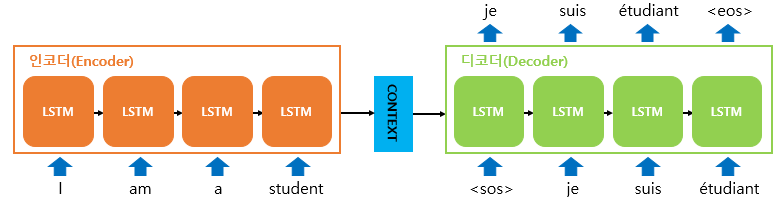

In [40]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/05/s2sdt.png')

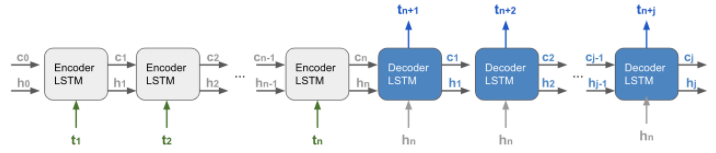

In [41]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/05/s2s.png')

In [42]:
n_hidden = 100 
# hidden layer수 지정

In [43]:
X_input_train.shape

(600, 200, 3)

In [44]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
# 입력층 (200, 2) index 제외
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
# 출력층 (20, 2) index 제외
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 2), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


* Encoder

In [45]:
encoder_last_h1, _, encoder_last_c = LSTM(n_hidden,
                                          activation='relu', 
                                          dropout=0.2, 
                                          recurrent_dropout=0.2,
                                          return_sequences=False,
                                          return_state=True)(input_train)

# output, hidden_state, cell_state 순으로 출력
# return_sequence = False이기에 층마다 h를 출력하지는 않음.
# return_state = True이기에 마지막 출력과 함께 hidden_state와 cell state 출력.
# -> decoder에게 전달해줘야함.

In [46]:
encder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

* Decoder

In [47]:
output_train.shape[1]

20

In [48]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
# input을 output_train.shape[1]만큼 복사
decoder = LSTM(n_hidden,
               activation='relu', 
               dropout=0.2, 
               recurrent_dropout=0.2,
               return_sequences=True,
               return_state=False)(decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


In [49]:
out= TimeDistributed(Dense(output_train.shape[2]))(decoder)
# TimeDistributed : LSTM이 many to many로 동작
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [50]:
model = Model(inputs = input_train, outputs = out)
opt = Adam(learning_rate = 0.01, clipnorm = 1)

# gradient cliping : https://kh-kim.gitbook.io/natural-language-processing-with-pytorch/00-cover-6/05-gradient-clipping
model.compile(loss='mean_squared_error', optimizer = opt, metrics = ['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 2)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        41200       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 20, 100)      0           ['lstm[0][0]']                   
                                                                                              

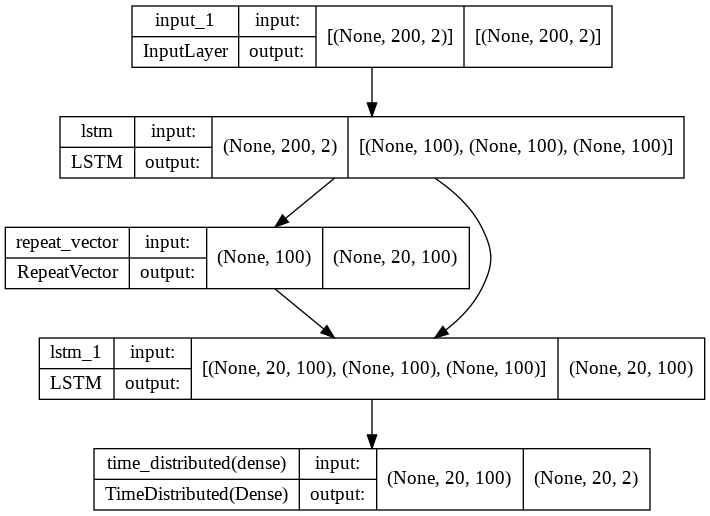

In [51]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

* train

In [52]:
!mkdir lstm

In [53]:
X_input_train[:,:,:2][0].shape

(200, 2)

In [54]:
X_output_train[:,:,:2][0].shape

(20, 2)

In [55]:
es = EarlyStopping(monitor='val_loss', mode='min', patience = 30)
# early stopping
history = model.fit(X_input_train[:,:,:2], X_output_train[:,:,:2], validation_split=0.2,
                    # index 제외
                    epochs=50, verbose =1 , callbacks=[es],
                    batch_size=100)

Epoch 1/50
5/5 [==============================] - 15s 1s/step - loss: 0.1500 - mae: 0.2790 - val_loss: 0.1476 - val_mae: 0.2765
Epoch 2/50
5/5 [==============================] - 7s 2s/step - loss: 0.1414 - mae: 0.2701 - val_loss: 0.1346 - val_mae: 0.2622
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.1310 - mae: 0.2611 - val_loss: 0.1225 - val_mae: 0.2673
Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 0.1284 - mae: 0.2616 - val_loss: 0.1245 - val_mae: 0.2510
Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 0.1201 - mae: 0.2515 - val_loss: 0.1071 - val_mae: 0.2418
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 0.1064 - mae: 0.2444 - val_loss: 0.0948 - val_mae: 0.2339
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 0.0925 - mae: 0.2270 - val_loss: 0.0805 - val_mae: 0.2126
Epoch 8/50
5/5 [==============================] - 5s 1s/step - loss: 0.0831 - mae: 0.2144 - val_loss: 0.0738 -

In [56]:
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
model.save('lstm/model_forecasting_seq2seq.h5')

* 학습 시각화

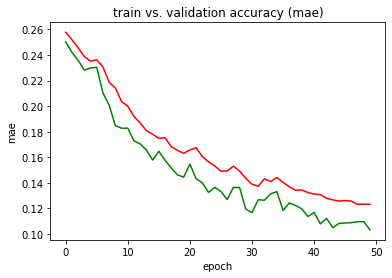

In [ ]:
plt.plot(train_mae, label='train mae', color='r')
plt.plot(valid_mae, label='validation mae', color='g')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
#plt.legend(loc = 'upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

* 예측

In [57]:
# 예측
train_pred_detrend = model.predict(X_input_train[:,:,:2])*x_train_max[:2]
                                                        # 예측하고 다시 정규화를 되돌린다.
test_pred_detrend = model.predict(X_input_test[:,:,:2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)

# 실제 값
train_true_detrend = X_output_train[:,:,:2]*x_train_max[:2]
test_true_detrend = X_output_test[:,:,:2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


* 예측값과 실제값 index와 결합 : 시각화를 위해서

In [58]:
# 예측 값
train_pred_detrend = np.concatenate([train_pred_detrend, 
                                     np.expand_dims(X_output_train[:,:,2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, 
                                     np.expand_dims(X_output_test[:,:,2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

# 실제 값
train_true_detrend = np.concatenate([train_true_detrend, 
                                     np.expand_dims(X_output_train[:,:,2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, 
                                     np.expand_dims(X_output_test[:,:,2], axis=2)], axis=2)
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


* 다시 트렌드를 더해주고 dict 형태로 만든다.

In [59]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend],
                 ['train_pred','train_true','test_pred','test_true']):
    dt_x1 = dt[:,:,0] + (dt[:,:,2]**2)*x1_trend_param[0] + dt[:,:,2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:,:,1] + dt[:,:,2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate([
        np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)
    ], axis=2)
    print(lb+": {}".format(data_final[lb].shape))

train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


* 예측값 분포와 실제값 분포의 비교

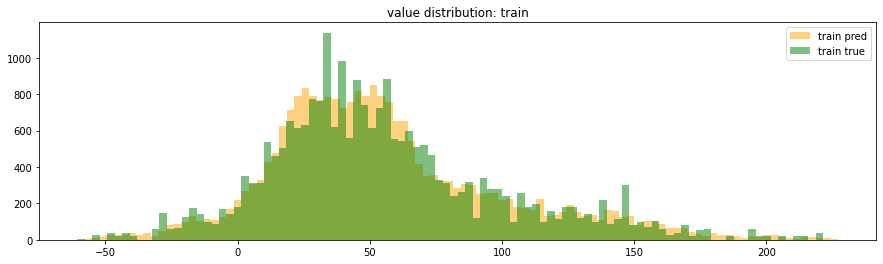

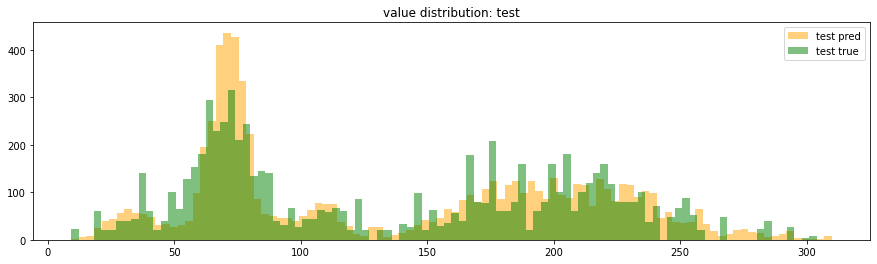

In [60]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15,4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color ='orange', alpha=0.5, label = lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color ='green', alpha=0.5, label = lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

* 시각화 


In [61]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
# 랜덤하게 전체 데이터 범위에서 특정 index를 가져오기

In [62]:
ith_timestep

6

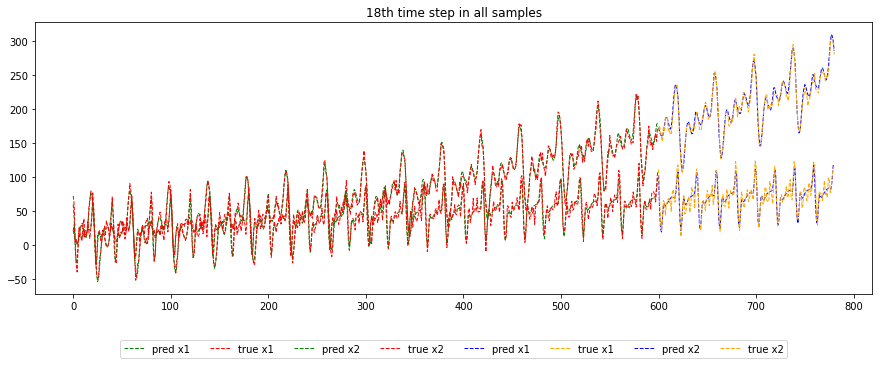

In [63]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
# 랜덤한 index 가져온다.
plt.figure(figsize=(15,5))
# 그래프 사이즈 지정
train_start_t = 0
# train 시작점 지정
test_start_t = data_final['train_pred'].shape[0]
# test 시작점 지정
for lb, tm, clrs in zip(['train','test'], [train_start_t, test_start_t],[['green','red'],['blue','orange']]):
  # train, test, 데이터 시작점, 그래프 색을 돌아가면서 받는다. 
    for i, x_lbl in zip([0,1], ['x1','x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]),
                data_final[lb+'_pred'][:, ith_timestep, i],
                linestyle="--", linewidth = 1, color = clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_true'].shape[0]),
                data_final[lb+'_true'][:, ith_timestep, i],
                linestyle="--", linewidth = 1, color = clrs[1], label='true '+x_lbl)
        # train 데이터의 시각화, test 데이터의 시각화 진행
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

* test 부분 확대해서 보기

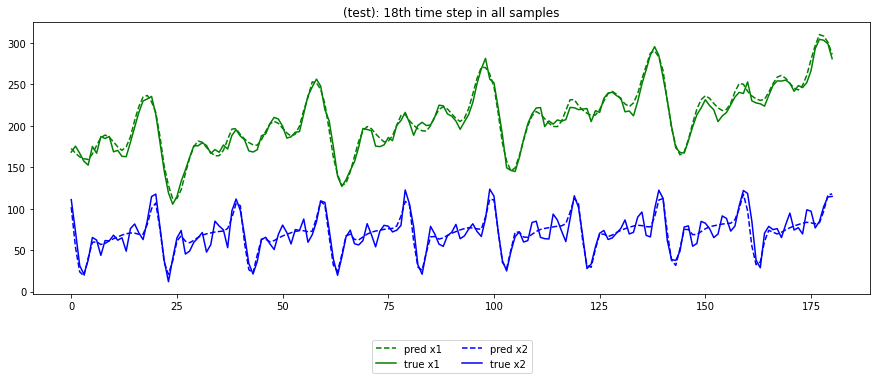

In [64]:
lb = 'test'
plt.figure(figsize=(15, 5))

for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
    # test 부분의 예측과 실제 시각화

plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

## Attention을 활용한 Seq2Seq LSTM Model

In [65]:
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

In [66]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='relu', 
    dropout=0.2, recurrent_dropout = 0.2,
    return_state = True, return_sequences=True)(input_train)

# output, hidden_state, cell_state 순으로 출력
# attention 계산을 위해서 stacked hidden state로 return
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 100), dtype=tf.float32, name=None), name='lstm_2/transpose_1:0', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_2/while:4', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_2/while:5', description="created by layer 'lstm_2'")


In [67]:
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [68]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
# encoder의 은닉상태 20번 입력 반복.
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='repeat_vector_1/Tile:0', description="created by layer 'repeat_vector_1'")


In [69]:
decoder_stack_h = LSTM(n_hidden, activation = 'relu',
                       dropout=0.2, 
                       recurrent_dropout=0.2,
                       return_state =False , 
                       return_sequences = True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
# decoder의 stacked hidden state도 return
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_3/transpose_1:0', description="created by layer 'lstm_3'")


In [70]:
attention = dot([decoder_stack_h, encoder_stack_h], axes = [2,2])
# encoder와 decoder의 stacked hidden state를 점곱한다 : 더 중요한 hidden state의 정보 강조
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [71]:
context = dot([attention, encoder_stack_h], axes = [2,1])
# 기존의 방식과 동일하게 하되 encode_stack_h에 attention을 점곱해준다 : 위에서 강조된 attention map을 encoder stack_h에 곱해준다.
context = BatchNormalization(momentum = 0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by layer 'batch_normalization_4'")


In [72]:
decoder_combined_context = concatenate([context, decoder_stack_h]) # attention 연산을 한 context
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [73]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
# TimeDistributed : LSTM이 many to many로 동작
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


In [74]:
model = Model(inputs=input_train, outputs = out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer = opt, metrics = ['mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 2)]     0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 200, 100),   41200       ['input_3[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 100)         400         ['lstm_2[0][1]']                 
 rmalization)                                                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


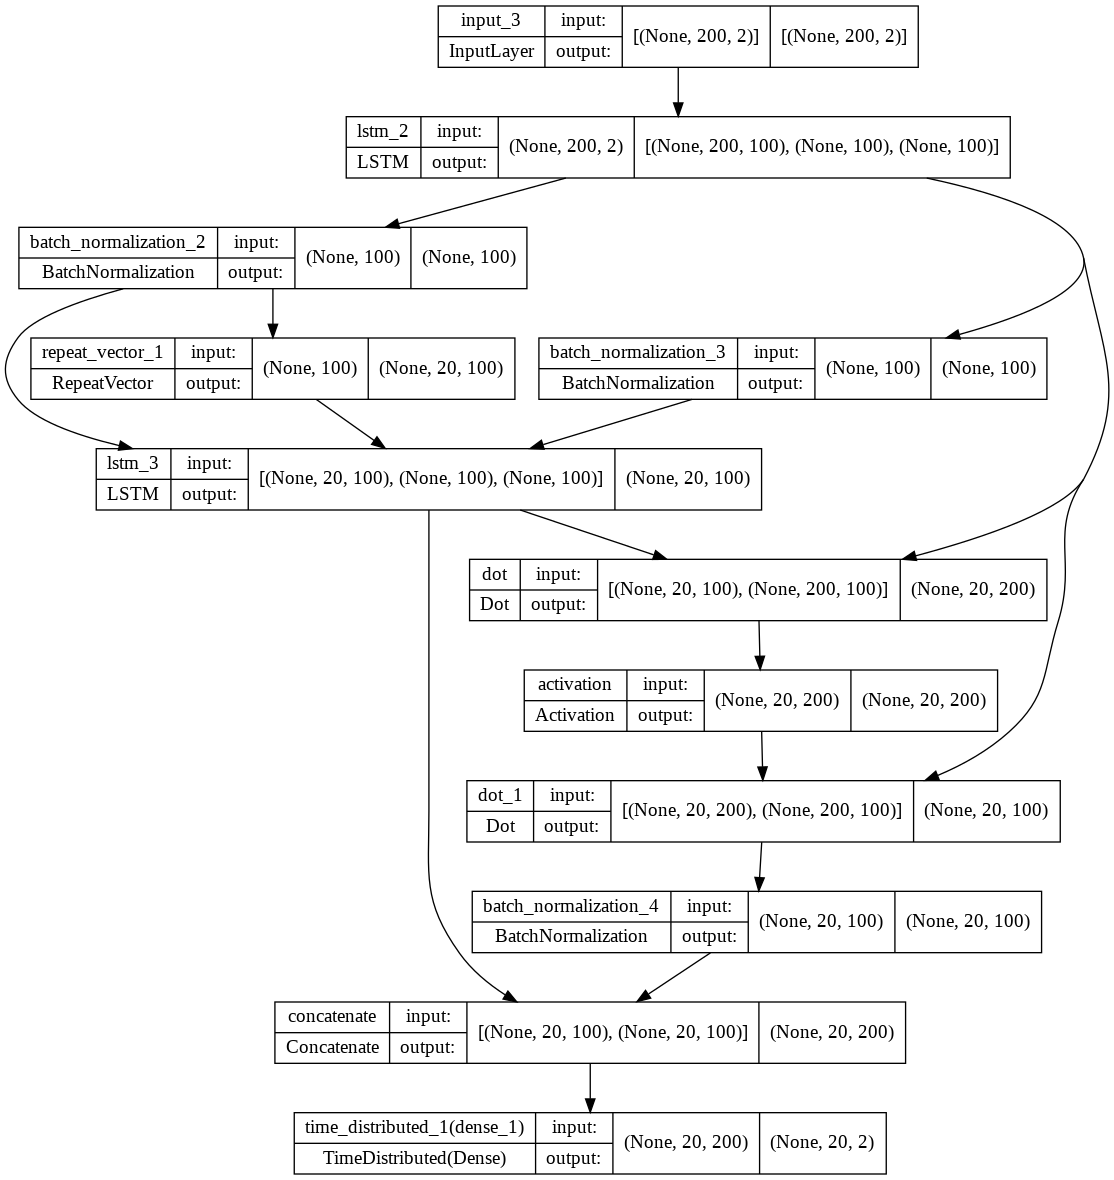

In [75]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

→ attention 추가

In [76]:
es = EarlyStopping(monitor='val_loss', mode='min', patience = 50)
history = model.fit(X_input_train[:,:,:2], X_output_train[:,:,:2], validation_split=0.2,
                    epochs=50, verbose =1 , callbacks=[es],
                    batch_size=100)

Epoch 1/50
5/5 [==============================] - 13s 2s/step - loss: 0.8443 - mae: 0.4679 - val_loss: 0.1605 - val_mae: 0.2901
Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 0.1544 - mae: 0.2890 - val_loss: 0.1544 - val_mae: 0.2830
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.1435 - mae: 0.2743 - val_loss: 0.1426 - val_mae: 0.2715
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 0.1346 - mae: 0.2655 - val_loss: 0.1318 - val_mae: 0.2666
Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 0.1244 - mae: 0.2583 - val_loss: 0.1173 - val_mae: 0.2542
Epoch 6/50
5/5 [==============================] - 5s 1s/step - loss: 0.1191 - mae: 0.2527 - val_loss: 0.1135 - val_mae: 0.2494
Epoch 7/50
5/5 [==============================] - 5s 1s/step - loss: 0.1133 - mae: 0.2458 - val_loss: 0.1102 - val_mae: 0.2428
Epoch 8/50
5/5 [==============================] - 5s 1s/step - loss: 0.1068 - mae: 0.2412 - val_loss: 0.0983 -

In [ ]:
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
model.save('lstm/model_forecasting_seq2seq.h5')

* 위와 동일한 시각화 과정 진행

In [ ]:
train_pred_detrend = model.predict(X_input_train[:,:,:2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:,:,:2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train[:,:,:2]*x_train_max[:2]
test_true_detrend = X_output_test[:,:,:2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)


(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


In [ ]:
train_pred_detrend = np.concatenate([train_pred_detrend, 
                                     np.expand_dims(X_output_train[:,:,2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, 
                                     np.expand_dims(X_output_test[:,:,2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = np.concatenate([train_true_detrend, 
                                     np.expand_dims(X_output_train[:,:,2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, 
                                     np.expand_dims(X_output_test[:,:,2], axis=2)], axis=2)
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [ ]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend],
                 ['train_pred','train_true','test_pred','test_true']):
    dt_x1 = dt[:,:,0] + (dt[:,:,2]**2)*x1_trend_param[0] + dt[:,:,2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:,:,1] + dt[:,:,2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate([
        np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)
    ], axis=2)
    print(lb+": {}".format(data_final[lb].shape))

train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


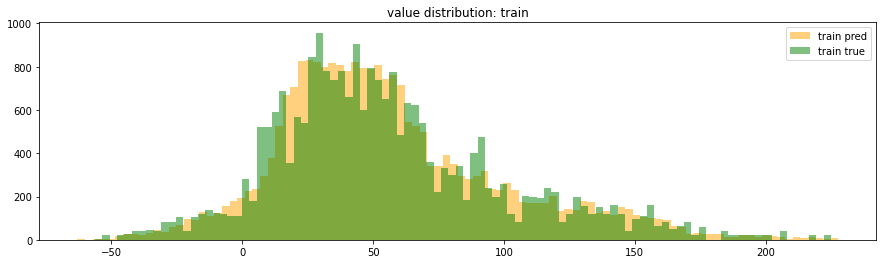

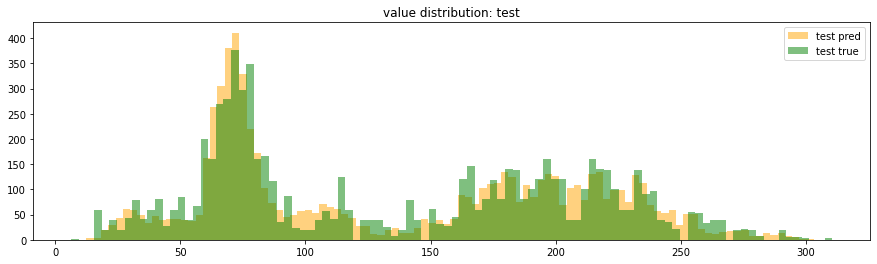

In [ ]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15,4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color ='orange', alpha=0.5, label = lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color ='green', alpha=0.5, label = lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

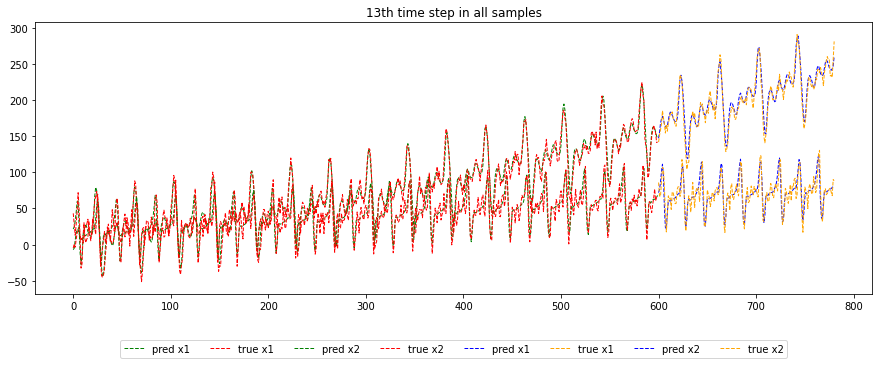

In [ ]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15,5))
train_start_t = 0 
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train','test'], [train_start_t, test_start_t],[['green','red'],['blue','orange']]):
    for i, x_lbl in zip([0,1], ['x1','x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]),
                data_final[lb+'_pred'][:, ith_timestep, i],
                linestyle="--", linewidth = 1, color = clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_true'].shape[0]),
                data_final[lb+'_true'][:, ith_timestep, i],
                linestyle="--", linewidth = 1, color = clrs[1], label='true '+x_lbl)
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

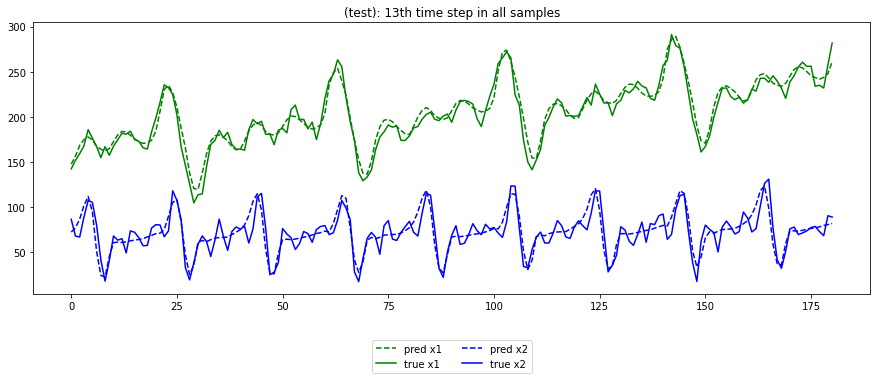

In [ ]:
lb = 'test'
plt.figure(figsize=(15,5))
for i, x_lbl, clr in zip([0,1], ['x1', 'x2'],['green','blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--',
            color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-',
            color=clr, label='true '+x_lbl)
    
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc = 'upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False, ncol=2)
plt.show()